# Basic classification

## 1. Importing libraries

In [16]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


## 2. Creating a fake dataset

In [17]:
# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

# Creating train and test data split
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible


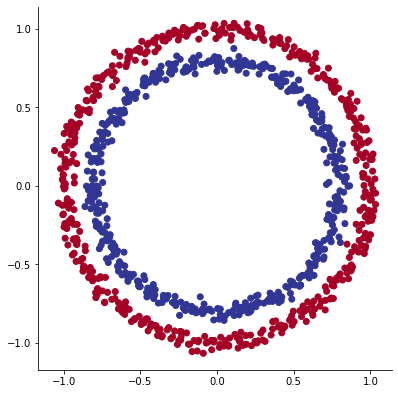

In [15]:
# Plotting
fig, ax = plt.subplots(1,1,figsize=(7,7))
fig.tight_layout(pad=6)

ax.scatter(x=X[:, 0], 
           y=X[:, 1], 
           c=y, 
           cmap=plt.cm.RdYlBu)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## 3. Defining model

In [105]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=5)
        self.layer_3 = nn.Linear(in_features=20, out_features=10)
        self.layer_4 = nn.Linear(in_features=10, out_features=1)
        self.relu = F.relu()
        
    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        return self.layer_4(x)
    

## 4. Model fitting and evaluation

In [78]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y1, y2):
    correct = torch.eq(y1, y2).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y1)) * 100 
    return acc

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


In [101]:
net = Net().to(device)

# Loss func and optimimizer
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [115]:



torch.manual_seed(42)
EPOCHS = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(EPOCHS):
    
    # Getting the prediction, loss and accuracy
    optimizer.zero_grad()
    y_pred = net(X_train).squeeze()
    loss = loss_fn(y_pred, y_train)
    train_accuracy = accuracy_fn(torch.round(torch.sigmoid(y_pred)), y_train)
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    
       
    # Testing
    net.eval()
    with torch.inference_mode():
        test_pred = net(X_test).squeeze()
        test_loss = loss_fn(test_pred, y_test)
        test_accuracy = accuracy_fn(torch.round(torch.sigmoid(test_pred)), y_test)
    
    if epoch % 100==0:
        print("epoch={} | train loss={} | train accuracy={} | test loss={} | test accuracy={}".
              format(epoch, loss, train_accuracy, test_loss, test_accuracy))
        

epoch=0 | train loss=0.0003412985533941537 | train accuracy=100.0 | test loss=0.003962676506489515 | test accuracy=100.0
epoch=100 | train loss=0.0003098494198638946 | train accuracy=100.0 | test loss=0.0038550538010895252 | test accuracy=100.0
epoch=200 | train loss=0.00028245014254935086 | train accuracy=100.0 | test loss=0.0037447374779731035 | test accuracy=100.0
epoch=300 | train loss=0.00025814707623794675 | train accuracy=100.0 | test loss=0.0036561465822160244 | test accuracy=100.0
epoch=400 | train loss=0.00023664049513172358 | train accuracy=100.0 | test loss=0.0035618823021650314 | test accuracy=100.0
epoch=500 | train loss=0.00021746419952251017 | train accuracy=100.0 | test loss=0.0034775796812027693 | test accuracy=100.0
epoch=600 | train loss=0.00020017809583805501 | train accuracy=100.0 | test loss=0.003399214707314968 | test accuracy=100.0
epoch=700 | train loss=0.00018463913875166327 | train accuracy=100.0 | test loss=0.0033244811929762363 | test accuracy=100.0
epoch=

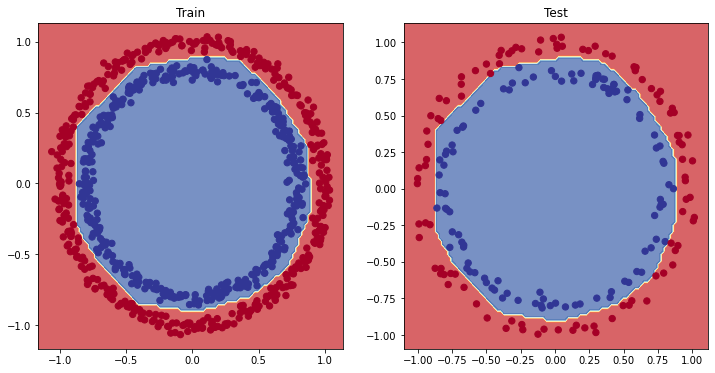

In [116]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(net, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(net, X_test, y_test)